# 1. Import Packages

In [23]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%run LDA_Example_Functions.ipynb
%matplotlib inline

# 2. Import Newsgroups Text Data

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

In [6]:
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [7]:
df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc
10000,From: a207706@moe.dseg.ti.com (Robert Loper)\n...,7,rec.autos
10001,From: kimman@magnus.acs.ohio-state.edu (Kim Ri...,6,misc.forsale
10002,From: kwilson@casbah.acns.nwu.edu (Kirtley Wil...,2,comp.os.ms-windows.misc
10003,Subject: Re: Don't more innocents die without ...,0,alt.atheism
10004,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,0,alt.atheism


# 3. Remove emails and newline characters

In [13]:
# Convert to list
data = df.content.values.tolist()
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:6: DeprecationWarning: invalid escape sequence \s
<input>:4: DeprecationWarning: invalid escape sequence \S
<input>:6: Dep

In [14]:
pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


# 4. Token and Clean-up using gensim's simple_preprocess()

In [22]:
data_words = list(sent_to_words(data))
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


# 5. Lemmatization

In [25]:
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


['where s  thing subject what car be nntp post host rac wam umd edu organization university maryland college park line be wonder anyone out there could enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know anyone can tellme model name engine spec year production where car be make history whatev info have funky look car mail thank bring  neighborhood lerxst', 'guy subject clock poll final call summary final call si clock report keyword acceleration clock upgrade article shelley qvfo innc organization university washington line nntp post host carson washington edu fair number brave soul who upgrade  si clock oscillator have share  experience poll send brief message detail  experience procedure top speed attain cpu rat speed add card adapter heat sink hour usage day floppy disk functionality floppy be especially request will be summarize next day so add network knowledge base have do clock

# 6. Create the Document-Word matrix

In [29]:
vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase = True, token_pattern='[a-zA-Z0-9]{3,}')
data_vectorized = vectorizer.fit_transform(data_lemmatized)

# 7. Check the Sparsicity

In [30]:
#materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.775887569365 %


# 8. Build LDA model with sklearn

In [31]:
lda_model = LatentDirichletAllocation(n_components=20, max_iter=10, learning_method = 'online', random_state = 100, batch_size = 128, evaluate_every = -1, n_jobs = -1)
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


# 9. Diagnose model performace with perplexity and log-likelihood

In [33]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better, Perplexity = exp(-1 * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model paramters
pprint(lda_model.get_params())

Log Likelihood:  -9942730.69998
Perplexity:  2026.01921242
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# 10. GridSearch

In [34]:
# Define Search Param
search_params = {'n_components': [10,15,20,25,30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20.

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# 11. Best topic model and its parameters

In [36]:
# Best model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Parameters: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Parameters:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -3421925.74395
Model Perplexity:  2084.07266487


# 12. Comparing LDA Model Peformance Scores

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


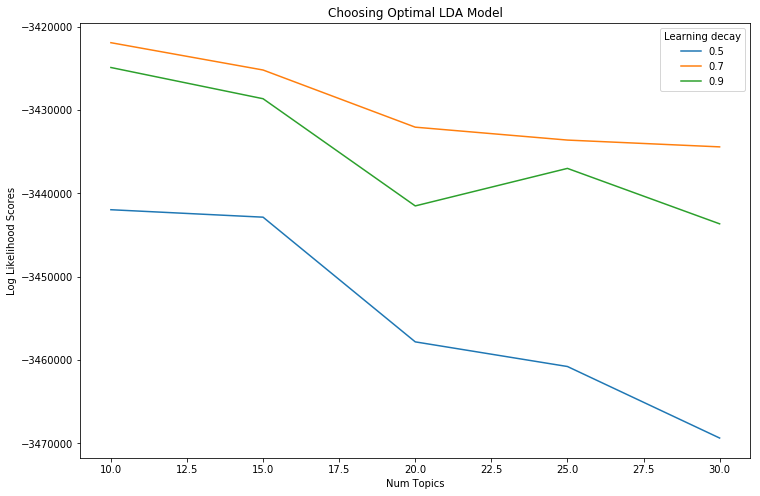

In [37]:
# Get Log Likelihoods from Grid Search Output
n_topics = [10,15,20,25,30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay'] == 0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay'] == 0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay'] == 0.9]

# Show graph
plt.figure(figsize=(12,8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

# 13. Dominant Topic in each Document

# 14. Topics Distribution across Documents

# 15. Visualizing LDA Model

In [38]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
7      19.744813        1       1  104.747124 -198.220596
5      19.326515        1       2   50.316330  182.406525
4      11.788113        1       3  -93.891052   90.797928
3      10.460721        1       4  232.324081  -75.891060
1      10.411767        1       5  -28.296255  -55.797825
8       7.804864        1       6 -160.519653  -53.067421
2       7.584548        1       7  183.156372   74.638969
0       5.182972        1       8  100.595055  -63.652405
9       4.659105        1       9   42.952084   51.932735
6       3.036582        1      10  -47.664524 -189.088974, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
5343  Default  4367.000000         max  4367.000000  30.0000  30.0000
4766  Default  2205.000000         key  2205.000000  29.0000  29.0000
3276  Default  3053.000000        file  3053.000000  28.0000  28.0000
8135  Default  2014.000000       space  2014.000000  27.0000  27.0000
3666  Default  2588.000000         god  2588.000000  26.0000  26.0000
2678  Default  2468.000000       drive  2468.000000  25.0000  25.0000
9218  Default  8910.000000         use  8910.000000  24.0000  24.0000
1269  Default  1578.000000        card  1578.000000  23.0000  23.0000
3790  Default  1684.000000         gun  1684.000000  22.0000  22.0000
6431  Default  5940.000000      people  5940.000000  21.0000  21.0000
3534  Default  1956.000000        game  1956.000000  20.0000  20.0000
9569  Default  3080.000000      window  3080.000000  19.0000  19.0000
1451  Default  1464.000000        chip  1464.000000  18.0000  18.0000
475   Default  1395.000000    armenian  1395.000000  17.0000  17.0000
6837  Default  2362.000000     program  2362.000000  16.0000  16.0000
905   Default  1959.000000         bit  1959.000000  15.0000  15.0000
1467  Default  1589.000000   christian  1589.000000  14.0000  14.0000
7636  Default  7068.000000         say  7068.000000  13.0000  13.0000
7698  Default   932.000000        scsi   932.000000  12.0000  12.0000
8640  Default  1541.000000        team  1541.000000  11.0000  11.0000
2680  Default  1107.000000      driver  1107.000000  10.0000  10.0000
3693  Default  1977.000000  government  1977.000000   9.0000   9.0000
2882  Default   867.000000  encryption   867.000000   8.0000   8.0000
4910  Default  2050.000000         law  2050.000000   7.0000   7.0000
8763  Default  5728.000000       think  5728.000000   6.0000   6.0000
9709  Default  3979.000000        year  3979.000000   5.0000   5.0000
3677  Default  6428.000000        good  6428.000000   4.0000   4.0000
5186  Default   980.000000         mac   980.000000   3.0000   3.0000
6581  Default  1441.000000        play  1441.000000   2.0000   2.0000
1563  Default   775.000000     clipper   775.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
8323  Topic10   121.123115         stl   122.011404   3.4871  -5.7911
9414  Topic10   120.230822        vram   121.120967   3.4871  -5.7985
5982  Topic10   119.394642       nubus   120.282901   3.4870  -5.8055
6000  Topic10   113.186746         nyi   114.075040   3.4866  -5.8589
6002  Topic10   108.642944         nyr   109.535982   3.4863  -5.8999
5975  Topic10    96.755268        nrhj    97.643523   3.4853  -6.0158
3007  Topic10    95.775460    ethernet    96.664061   3.4852  -6.0259
4706  Topic10   182.248205      jumper   184.161051   3.4840  -5.3826
1915  Topic10   466.866545  controller   485.512865   3.4553  -4.4419
1269  Topic10  1329.823908        card  1578.981080   3.3227  -3.3951
1169  Topic10   491.374943         bus   559.141171   3.3652  -4.3907
8021  Topic10   207.810729        slot   221.852167   3.4291  -5.2513
5527  Topic10   167.756367         min   175.447705   3.4496  -5.4654
5630  Topic10   206.127860         mon   